<a href="https://colab.research.google.com/github/Rishiatweb/Data-Science-Assessment/blob/main/DataScienceAssessment_EDA_and_Model_choice_experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Step 1: Upload your dataset
from google.colab import files

print("Please upload 'Assessment-2-Associate-DS(in).csv'")
uploaded = files.upload()
file_name = 'Assessment-2-Associate-DS(in).csv'
if file_name not in uploaded:
    print(f"\nERROR: File '{file_name}' not found. Please run this cell again and upload the correct file.")
else:
    print(f"\nSUCCESS: '{file_name}' uploaded successfully!")

Please upload 'Assessment-2-Associate-DS(in).csv'


Saving Assessment-2-Associate-DS(in).csv to Assessment-2-Associate-DS(in).csv

SUCCESS: 'Assessment-2-Associate-DS(in).csv' uploaded successfully!


In [2]:
!pip install pandas xgboost scikit-learn matplotlib seaborn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import joblib
import os

print("Libraries imported successfully.")

Libraries imported successfully.


In [3]:
try:
    df = pd.read_csv(file_name)
    print("--- Data Head ---")
    display(df.head())
    print("\n--- Data Info ---")
    df.info()
    print("\n--- Missing Values ---")
    print(df.isnull().sum())
except FileNotFoundError:
    print("Error: Please run the upload cell at the top first.")

--- Data Head ---


,weekend_date,channel,brand,category,sub_category,SerailNum,quantity
0,4/6/2022,Channel1,B1,Cat2,Sub-Cat2,1,56
1,11/6/2022,Channel1,B1,Cat2,Sub-Cat2,1,122
2,18/06/2022,Channel1,B1,Cat2,Sub-Cat2,1,102
3,25/06/2022,Channel1,B1,Cat2,Sub-Cat2,1,128
4,2/7/2022,Channel1,B1,Cat2,Sub-Cat2,1,97



--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   weekend_date  600 non-null    object
 1   channel       600 non-null    object
 2   brand         600 non-null    object
 3   category      600 non-null    object
 4   sub_category  600 non-null    object
 5   SerailNum     600 non-null    int64 
 6   quantity      600 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 32.9+ KB

--- Missing Values ---
weekend_date    0
channel         0
brand           0
category        0
sub_category    0
SerailNum       0
quantity        0
dtype: int64


In [4]:
# @title 1.2: Data Cleaning and Preprocessing
print("--- Cleaning and Preprocessing Data ---")

# Standardizing the 'weekend_date' column to datetime objects
# The 'dayfirst=True' argument correctly interprets dates like '4/6/2022' as DD/MM/YYYY
# I used .dt.normalize() to removes the time part, setting all to midnight.
df['weekend_date'] = pd.to_datetime(df['weekend_date'], dayfirst=True, errors='coerce').dt.normalize()

# Dropping any rows where date conversion might have failed
df.dropna(subset=['weekend_date'], inplace=True)

# Sort the data by series and date to ensure correct time-series order
df.sort_values(by=['SerailNum', 'weekend_date'], inplace=True)
df.reset_index(drop=True, inplace=True)

print("\nData after cleaning and standardizing dates:")
display(df.head())

unique_series = df['SerailNum'].unique()
print(f"\nFound {len(unique_series)} unique time series (by SerailNum): {unique_series}")

--- Cleaning and Preprocessing Data ---

Data after cleaning and standardizing dates:


,weekend_date,channel,brand,category,sub_category,SerailNum,quantity
0,2022-06-04,Channel1,B1,Cat2,Sub-Cat2,1,56
1,2022-06-11,Channel1,B1,Cat2,Sub-Cat2,1,122
2,2022-06-18,Channel1,B1,Cat2,Sub-Cat2,1,102
3,2022-06-25,Channel1,B1,Cat2,Sub-Cat2,1,128
4,2022-07-02,Channel1,B1,Cat2,Sub-Cat2,1,97



Found 4 unique time series (by SerailNum): [1 2 4 5]


In [38]:
print("\n--- Descriptive Statistics ---")
display(df.describe())

print("\n--- Descriptive Statistics (Object Type Columns) ---")
display(df.describe(include='object'))


--- Descriptive Statistics ---


,weekend_date,SerailNum,quantity
count,494,494.000000,494.000000
mean,2023-08-29 00:46:38.380566784,3.058704,493.722672
min,2022-05-28 00:00:00,1.000000,1.000000
25%,2023-03-12 18:00:00,2.000000,115.250000
50%,2023-09-09 00:00:00,4.000000,216.500000
75%,2024-03-02 00:00:00,4.000000,533.500000
max,2024-08-31 00:00:00,5.000000,8051.000000
std,NaN,1.542697,886.086396



--- Descriptive Statistics (Object Type Columns) ---


,channel,brand,category,sub_category
count,494,494,494,494
unique,2,2,3,4
top,Channel2,B1,Cat3,Sub-Cat3
freq,376,312,267,182



--- Descriptive Statistics ---


,weekend_date,channel,brand,category,sub_category,SerailNum,quantity
count,494,494,494,494,494,494.000000,494.000000
unique,NaN,2,2,3,4,NaN,NaN
top,NaN,Channel2,B1,Cat3,Sub-Cat3,NaN,NaN
freq,NaN,376,312,267,182,NaN,NaN
mean,2023-08-29 00:46:38.380566784,NaN,NaN,NaN,NaN,3.058704,493.722672
min,2022-05-28 00:00:00,NaN,NaN,NaN,NaN,1.000000,1.000000
25%,2023-03-12 18:00:00,NaN,NaN,NaN,NaN,2.000000,115.250000
50%,2023-09-09 00:00:00,NaN,NaN,NaN,NaN,4.000000,216.500000
75%,2024-03-02 00:00:00,NaN,NaN,NaN,NaN,4.000000,533.500000
max,2024-08-31 00:00:00,NaN,NaN,NaN,NaN,5.000000,8051.000000



Visualizing distributions for numerical columns: ['SerailNum', 'quantity']


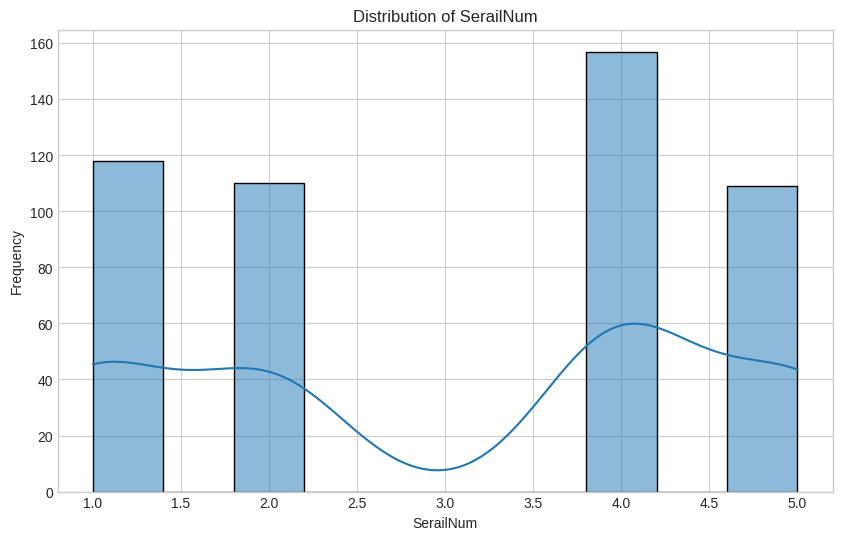

Skipping distribution plot for 'quantity' due to high number of unique values (355)

Visualizing counts for categorical columns: ['channel', 'brand', 'category', 'sub_category']


/tmp/ipython-input-39-4241585500.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, order=df[col].value_counts().index, palette='viridis')


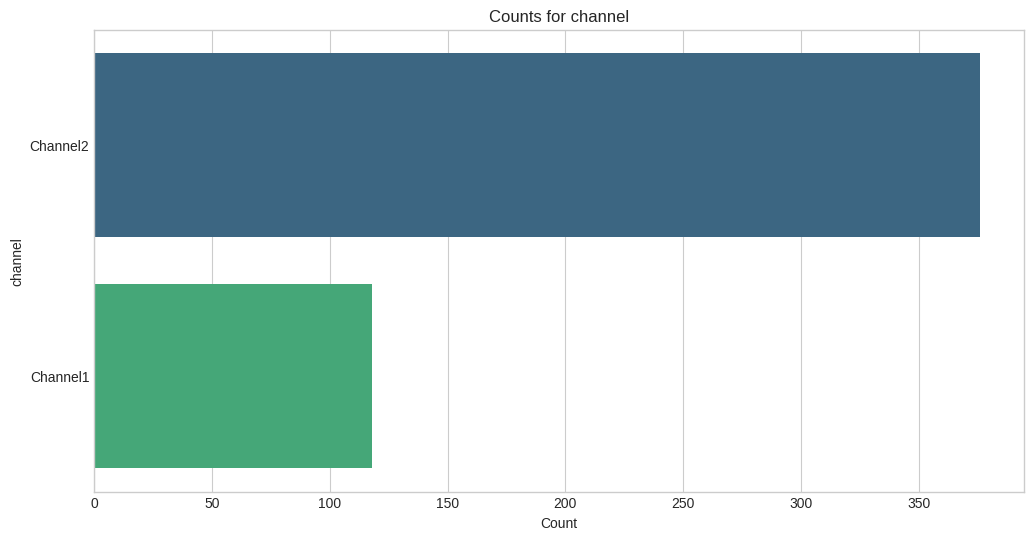

/tmp/ipython-input-39-4241585500.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, order=df[col].value_counts().index, palette='viridis')


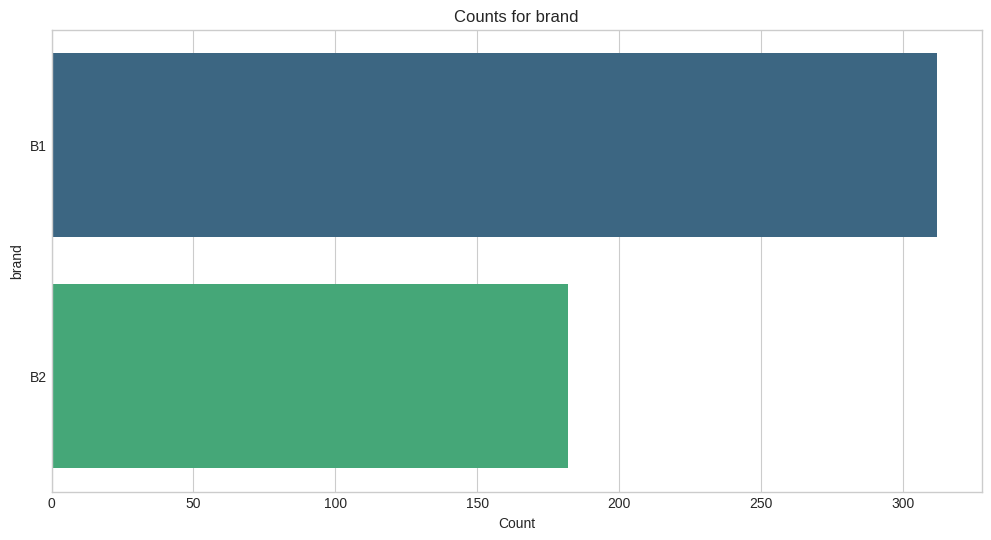

/tmp/ipython-input-39-4241585500.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, order=df[col].value_counts().index, palette='viridis')


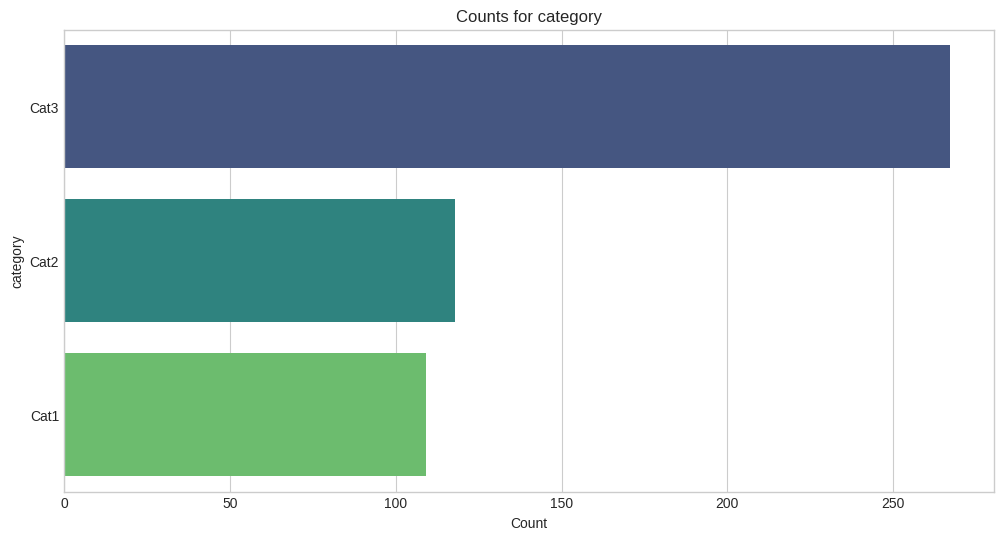

/tmp/ipython-input-39-4241585500.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, order=df[col].value_counts().index, palette='viridis')


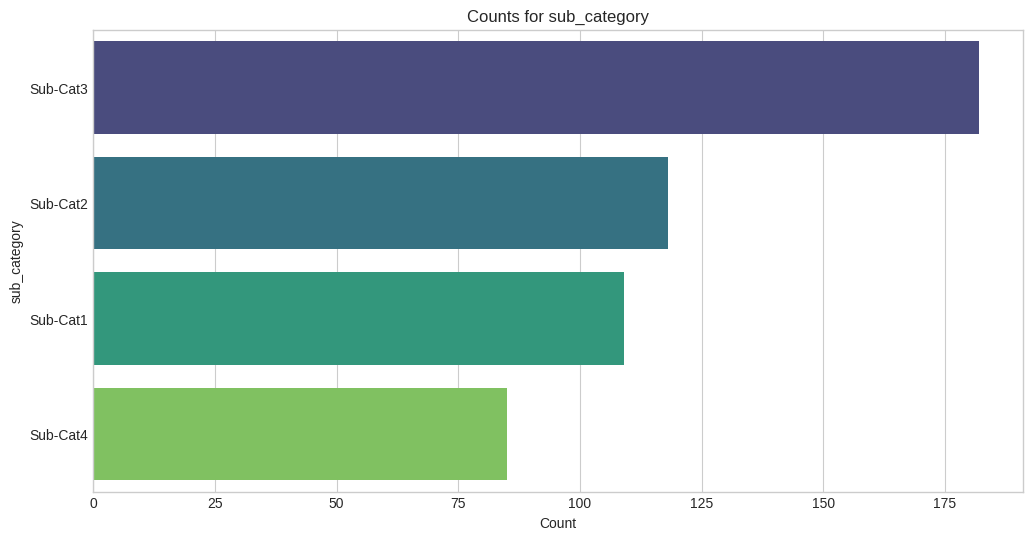


Descriptive statistics and visualizations complete.
--- Value Counts for Categorical and Limited Numerical Columns ---

Value counts for 'channel':
channel
Channel2    376
Channel1    118
Name: count, dtype: int64
--------------------

Value counts for 'brand':
brand
B1    312
B2    182
Name: count, dtype: int64
--------------------

Value counts for 'category':
category
Cat3    267
Cat2    118
Cat1    109
Name: count, dtype: int64
--------------------

Value counts for 'sub_category':
sub_category
Sub-Cat3    182
Sub-Cat2    118
Sub-Cat1    109
Sub-Cat4     85
Name: count, dtype: int64
--------------------

Exploratory Data Analysis complete. Proceeding to modeling steps if applicable.


/tmp/ipython-input-39-4241585500.py:35: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df[col].dtype == 'object' or (df[col].dtype in [np.number] and df[col].nunique() < 20):
/tmp/ipython-input-39-4241585500.py:35: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df[col].dtype == 'object' or (df[col].dtype in [np.number] and df[col].nunique() < 20):


In [39]:
print("\n--- Descriptive Statistics ---")
display(df.describe(include='all'))
numerical_cols = df.select_dtypes(include=np.number).columns
print(f"\nVisualizing distributions for numerical columns: {list(numerical_cols)}")
if len(numerical_cols) > 0:
    for col in numerical_cols:
        if df[col].nunique() > 50 and df[col].dtype != 'datetime64[ns]':
            print(f"Skipping distribution plot for '{col}' due to high number of unique values ({df[col].nunique()})")
            continue
        plt.figure(figsize=(10, 6))
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
categorical_cols = df.select_dtypes(include='object').columns
print(f"\nVisualizing counts for categorical columns: {list(categorical_cols)}")

if len(categorical_cols) > 0:
    for col in categorical_cols:
        if df[col].nunique() > 20:
            print(f"Skipping count plot for '{col}' due to high number of unique categories ({df[col].nunique()})")
            continue
        plt.figure(figsize=(12, 6))
        sns.countplot(data=df, y=col, order=df[col].value_counts().index, palette='viridis')
        plt.title(f'Counts for {col}')
        plt.xlabel('Count')
        plt.ylabel(col)
        plt.show()

print("\nDescriptive statistics and visualizations complete.")
print("--- Value Counts for Categorical and Limited Numerical Columns ---")
for col in df.columns:
    if df[col].dtype == 'object' or (df[col].dtype in [np.number] and df[col].nunique() < 20):
        print(f"\nValue counts for '{col}':")
        print(df[col].value_counts())
        print("-" * 20)

print("\nExploratory Data Analysis complete. Proceeding to modeling steps if applicable.")


--- Visualizing Each Time Series ---


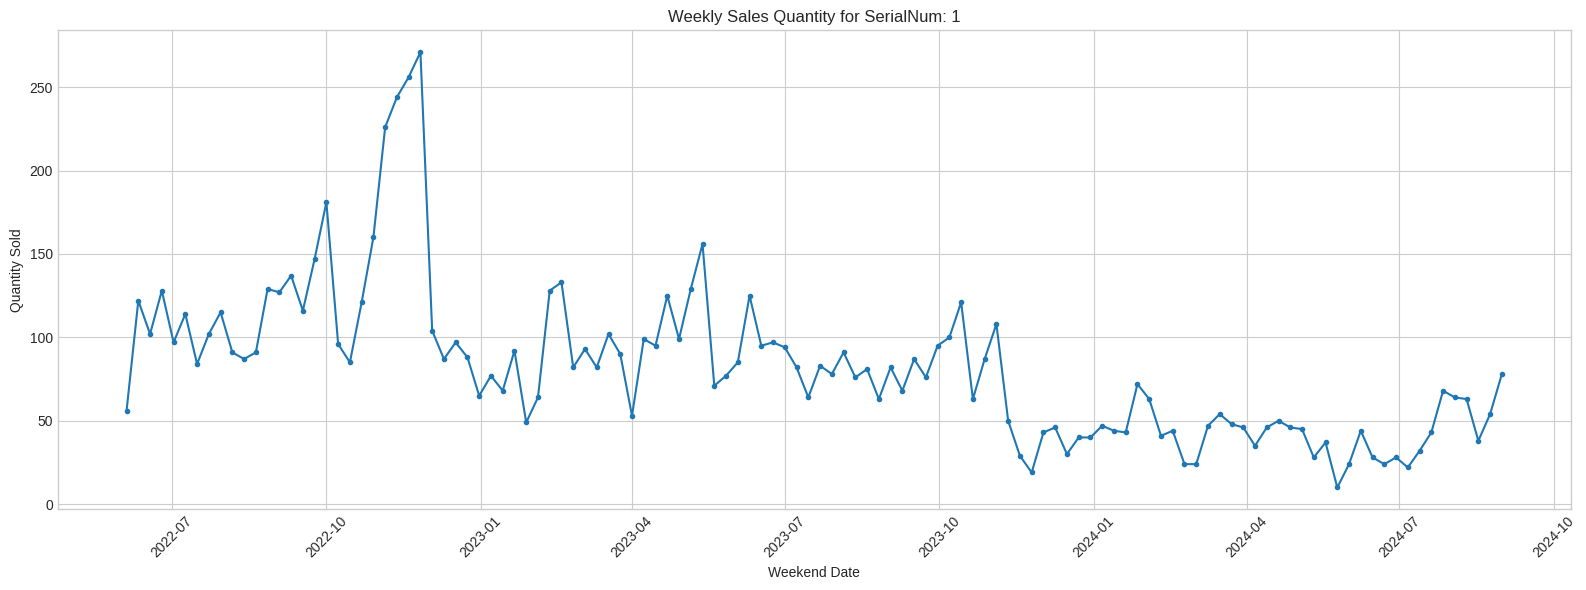

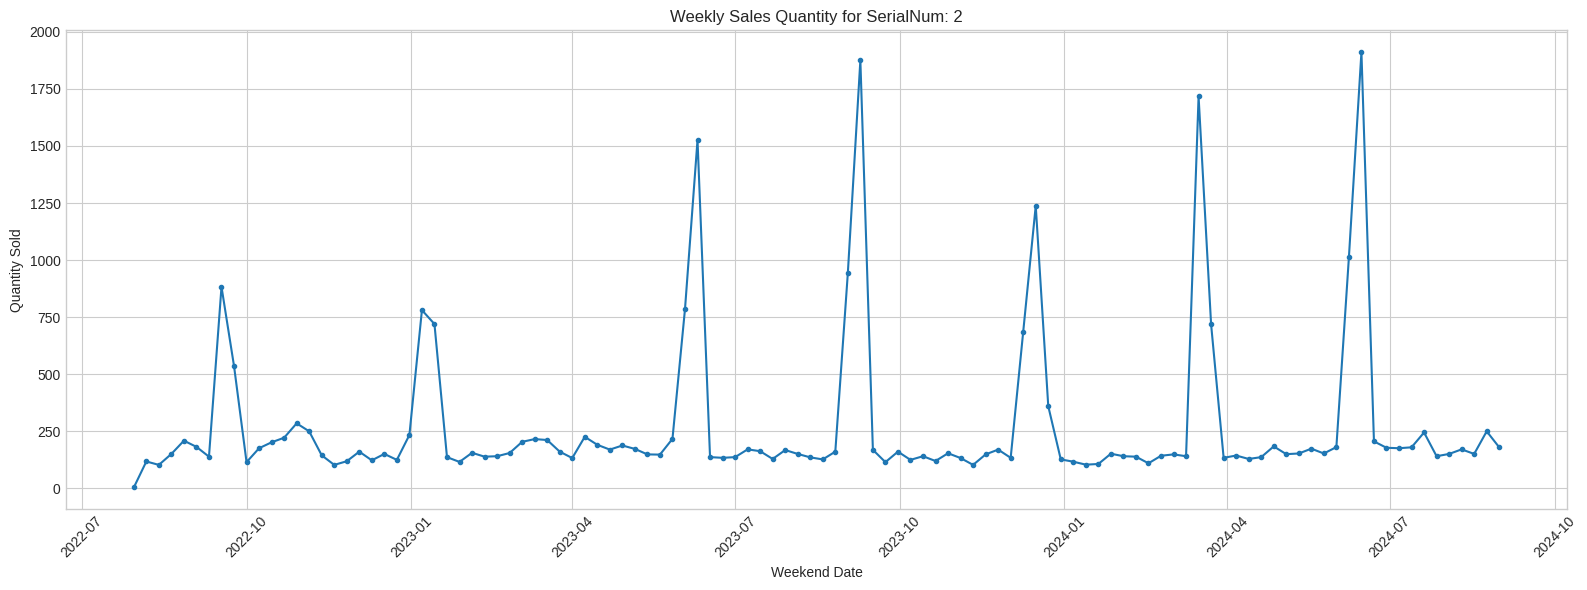

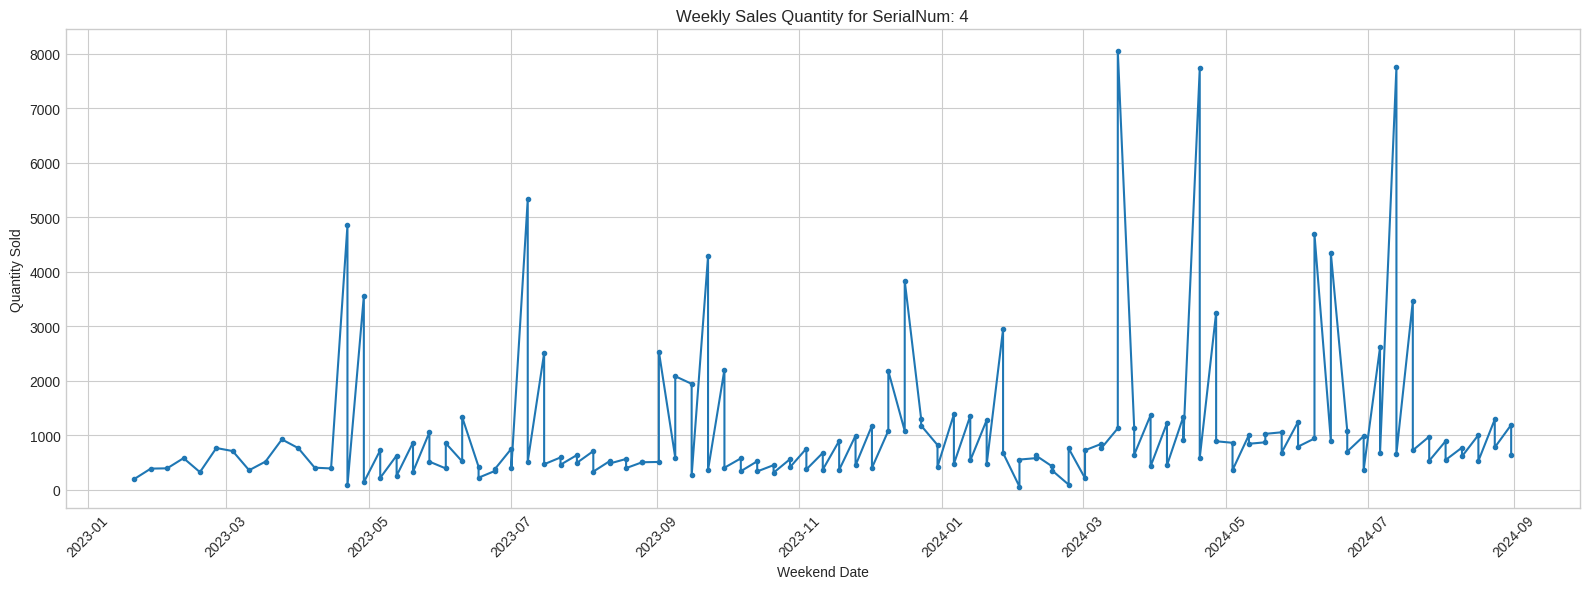

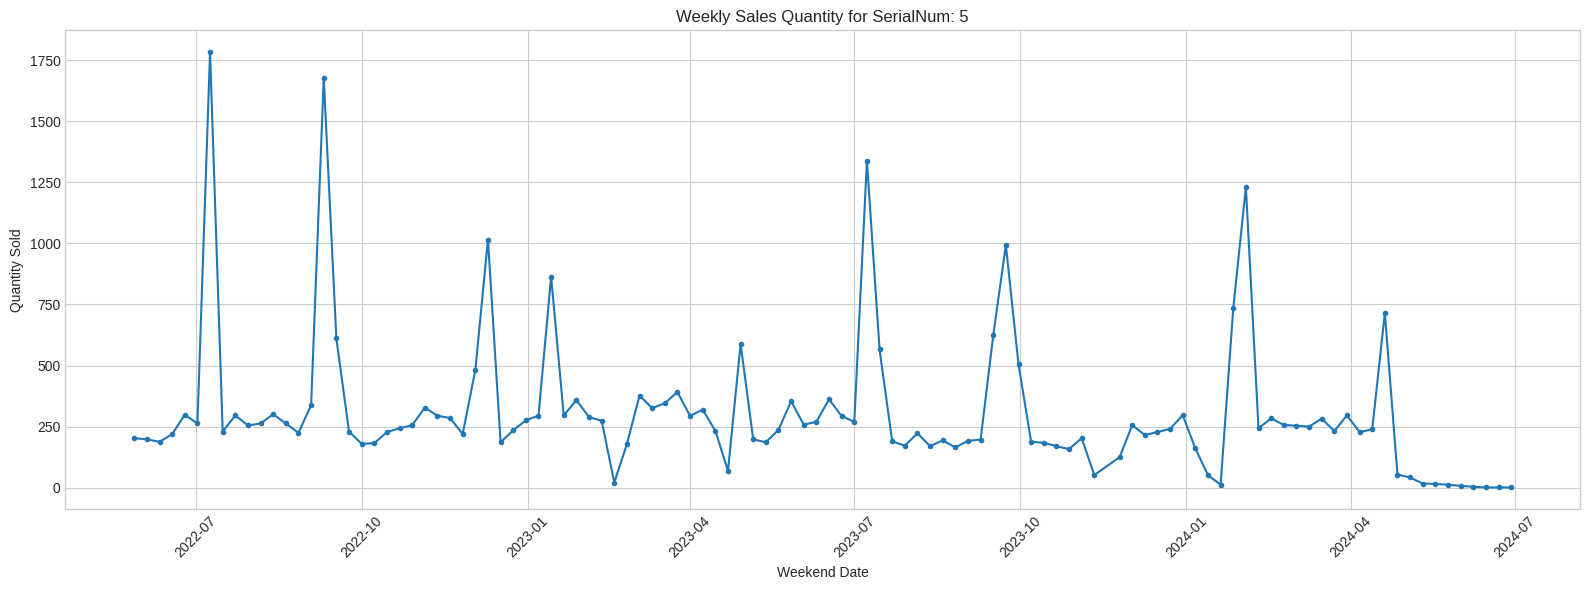

In [5]:
# @title Visualize Weekly Sales Data
print("--- Visualizing Each Time Series ---")
plt.style.use('seaborn-v0_8-whitegrid')

for sid in unique_series:
    plt.figure(figsize=(16, 6))
    series_data = df[df['SerailNum'] == sid]
    plt.plot(series_data['weekend_date'], series_data['quantity'], marker='.', linestyle='-')
    plt.title(f'Weekly Sales Quantity for SerialNum: {sid}')
    plt.xlabel('Weekend Date')
    plt.ylabel('Quantity Sold')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [6]:
df

,weekend_date,channel,brand,category,sub_category,SerailNum,quantity
0,2022-06-04,Channel1,B1,Cat2,Sub-Cat2,1,56
1,2022-06-11,Channel1,B1,Cat2,Sub-Cat2,1,122
2,2022-06-18,Channel1,B1,Cat2,Sub-Cat2,1,102
3,2022-06-25,Channel1,B1,Cat2,Sub-Cat2,1,128
4,2022-07-02,Channel1,B1,Cat2,Sub-Cat2,1,97
...,...,...,...,...,...,...,...
489,2024-06-01,Channel2,B1,Cat1,Sub-Cat1,5,8
490,2024-06-08,Channel2,B1,Cat1,Sub-Cat1,5,4
491,2024-06-15,Channel2,B1,Cat1,Sub-Cat1,5,1
492,2024-06-22,Channel2,B1,Cat1,Sub-Cat1,5,1


In [7]:
# @title Feature Engineering
def create_features(data):
    """Creates time-series features from a datetime index and lag/rolling features."""
    df_feat = data.copy()
    df_feat['year'] = df_feat['weekend_date'].dt.year
    df_feat['month'] = df_feat['weekend_date'].dt.month
    df_feat['week_of_year'] = df_feat['weekend_date'].dt.isocalendar().week.astype(int)
    df_feat['day_of_year'] = df_feat['weekend_date'].dt.dayofyear

    # Lag features (past values) - grouped by series to prevent data leakage
    for lag in [1, 2, 3, 4, 52]: # Lags from recent weeks and the same week last year
        df_feat[f'lag_{lag}'] = df_feat.groupby('SerailNum')['quantity'].shift(lag)

    # Rolling window features (e.g., average of last 4 weeks)
    for window in [4, 8, 52]:
        df_feat[f'rolling_mean_{window}'] = df_feat.groupby('SerailNum')['quantity'].shift(1).rolling(window).mean()
        df_feat[f'rolling_std_{window}'] = df_feat.groupby('SerailNum')['quantity'].shift(1).rolling(window).std()

    return df_feat

df_featured = create_features(df)

# Encode categorical features so the model can use them
categorical_cols = ['channel', 'brand', 'category', 'sub_category', 'SerailNum']
for col in categorical_cols:
    df_featured[col] = df_featured[col].astype('category')

print("Feature engineering complete. Example of features for one row:")
display(df_featured.tail(1).T)

Feature engineering complete. Example of features for one row:


,493
weekend_date,2024-06-29 00:00:00
channel,Channel2
brand,B1
category,Cat1
sub_category,Sub-Cat1
SerailNum,5
quantity,1
year,2024
month,6
week_of_year,26


In [8]:
# @title Model Building and Training
print("--- Building and Training the LightGBM Model ---")

# Define validation period: June, July, August 2024
train_cutoff = pd.to_datetime('2024-06-01')
val_cutoff = pd.to_datetime('2024-09-01')

# Split data into training and validation sets
train_df = df_featured[df_featured['weekend_date'] < train_cutoff]
val_df = df_featured[(df_featured['weekend_date'] >= train_cutoff) & (df_featured['weekend_date'] < val_cutoff)]

# Define features and target
features = [
    'year', 'month', 'week_of_year', 'day_of_year',
    'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_52',
    'rolling_mean_4', 'rolling_std_4', 'rolling_mean_8', 'rolling_std_8',
    'rolling_mean_52', 'rolling_std_52',
    'SerailNum', 'channel', 'brand', 'category', 'sub_category'
]
target = 'quantity'

X_train = train_df[features]
y_train = train_df[target]
X_val = val_df[features]
y_val = val_df[target]

# Initialize and train the model
# 'objective=regression_l1' (MAE) is robust to the sales spikes we saw
lgbm = lgb.LGBMRegressor(
    objective='regression_l1',
    n_estimators=1000,
    learning_rate=0.05,
    n_jobs=-1,
    seed=42
)

print("Training model with early stopping...")
lgbm.fit(X_train, y_train,
         eval_set=[(X_val, y_val)],
         eval_metric='mae',
         callbacks=[lgb.early_stopping(100, verbose=False)])

print("Model training complete.")

--- Building and Training the LightGBM Model ---
Training model with early stopping...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1538
[LightGBM] [Info] Number of data points in the train set: 433, number of used features: 20
[LightGBM] [Info] Start training from score 216.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [9]:
# @title Validate on Jun-Jul-Aug 2024 and Calculate Accuracy
print("--- Validating Model and Calculating Monthly Accuracy ---")

# Predict on the validation set
val_preds = lgbm.predict(X_val)

# Add predictions to a results DataFrame
val_results = val_df.copy()
val_results['prediction'] = np.maximum(0, val_preds) # Sales can't be negative

# Define the accuracy metric as requested
def calculate_monthly_accuracy(group):
    actuals = group['quantity']
    preds = group['prediction']

    # Handle the case where actual sales are 0 to avoid division by zero
    if actuals.sum() == 0:
      return 1.0 if (preds - actuals).abs().sum() == 0 else 0.0

    accuracy = 1 - (np.abs(preds - actuals).sum() / actuals.sum())
    return accuracy

# Calculate accuracy per month and per series
val_results['month_name'] = val_results['weekend_date'].dt.strftime('%B')
monthly_accuracy = val_results.groupby(['SerailNum', 'month_name']).apply(calculate_monthly_accuracy).reset_index(name='accuracy')

# Pivot for a clear report
accuracy_pivot = monthly_accuracy.pivot_table(index='SerailNum', columns='month_name', values='accuracy')
accuracy_pivot = accuracy_pivot[['June', 'July', 'August']] # Ensure column order

print("\nValidation Accuracy for Jun-Jul-Aug 2024 (1 - WAPE):")
display(accuracy_pivot.round(3))

--- Validating Model and Calculating Monthly Accuracy ---

Validation Accuracy for Jun-Jul-Aug 2024 (1 - WAPE):


/tmp/ipython-input-9-1158937107.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_accuracy = val_results.groupby(['SerailNum', 'month_name']).apply(calculate_monthly_accuracy).reset_index(name='accuracy')
/tmp/ipython-input-9-1158937107.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_accuracy = val_results.groupby(['SerailNum', 'month_name']).apply(calculate_monthly_accuracy).reset_index(name='accuracy')
/tmp/ipython-input-9-1158937107.py:28: FutureWarning: The default value of observ

month_name,June,July,August
SerailNum,,,
1,0.620,0.657,0.833
2,0.343,0.651,0.648
4,0.478,0.357,0.783
5,-26.296,NaN,NaN


In [10]:
# @title Generate Forecast for Sep-Oct-Nov 2024
print("--- Generating Forecast for Sep, Oct, Nov 2024 ---")

# Create a future dataframe for the next 3 months
future_dates = pd.date_range(start='2024-09-01', end='2024-11-30', freq='W-SAT')
unique_series_ids = df['SerailNum'].unique()

# Create a template with future dates for all series
future_df_list = []
for sid in unique_series_ids:
    last_known_row = df[df['SerailNum'] == sid].iloc[-1]
    temp_df = pd.DataFrame({'weekend_date': future_dates, 'SerailNum': sid})
    for col in ['channel', 'brand', 'category', 'sub_category']:
        temp_df[col] = last_known_row[col]
    future_df_list.append(temp_df)
future_df_template = pd.concat(future_df_list)

# Use a recursive strategy: predict one week, add it to history, then predict the next
history = df_featured.copy() # Start with the full featured history

forecast_results_list = []

for date in future_dates:
    # Combine history with the template for the weeks we need to predict
    # This ensures we can create features for the future dates
    combined_history = pd.concat([history, future_df_template[future_df_template['weekend_date'] == date]])

    # Ensure categorical features have consistent categories before creating features
    categorical_cols = ['channel', 'brand', 'category', 'sub_category', 'SerailNum']
    for col in categorical_cols:
        combined_history[col] = combined_history[col].astype('category')
        # Ensure the categories are the same as the training data
        combined_history[col] = combined_history[col].cat.set_categories(df_featured[col].cat.categories)


    # Create features for the combined data
    current_week_features = create_features(combined_history)

    # Isolate just the rows for the current week we want to predict
    features_to_predict = current_week_features[current_week_features['weekend_date'] == date].copy()

    # Predict
    preds = lgbm.predict(features_to_predict[features])

    # Store predictions
    features_to_predict['quantity'] = np.maximum(0, preds)
    forecast_results_list.append(features_to_predict[['SerailNum', 'weekend_date', 'quantity']])

    # Append the new 'actual' (our prediction) to history for the next loop iteration
    history = pd.concat([history, features_to_predict[['SerailNum', 'weekend_date', 'quantity']]])
    history.sort_values(by=['SerailNum', 'weekend_date'], inplace=True)

# Combine all weekly forecasts into a final DataFrame
final_forecast_df = pd.concat(forecast_results_list).reset_index(drop=True)
final_forecast_df['quantity'] = final_forecast_df['quantity'].round(0).astype(int)

print("\nForecasted Weekly Sales for Sep, Oct, Nov 2024:")
display(final_forecast_df)

--- Generating Forecast for Sep, Oct, Nov 2024 ---


/tmp/ipython-input-7-628611469.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_feat[f'lag_{lag}'] = df_feat.groupby('SerailNum')['quantity'].shift(lag)
/tmp/ipython-input-7-628611469.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_feat[f'rolling_mean_{window}'] = df_feat.groupby('SerailNum')['quantity'].shift(1).rolling(window).mean()
/tmp/ipython-input-7-628611469.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence thi


Forecasted Weekly Sales for Sep, Oct, Nov 2024:


/tmp/ipython-input-7-628611469.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_feat[f'lag_{lag}'] = df_feat.groupby('SerailNum')['quantity'].shift(lag)
/tmp/ipython-input-7-628611469.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_feat[f'rolling_mean_{window}'] = df_feat.groupby('SerailNum')['quantity'].shift(1).rolling(window).mean()
/tmp/ipython-input-7-628611469.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence thi

,SerailNum,weekend_date,quantity
0,1,2024-09-07,81
1,2,2024-09-07,175
2,4,2024-09-07,669
3,5,2024-09-07,92
4,1,2024-09-14,84
5,2,2024-09-14,165
6,4,2024-09-14,625
7,5,2024-09-14,124
8,1,2024-09-21,89
9,2,2024-09-21,153


In [11]:
# @title Save and Download the Final Model
# Create a directory to save the model
if not os.path.exists('models'):
    os.makedirs('models')

# Save the fitted model object
model_path = 'models/lgbm_global_forecaster.joblib'
joblib.dump(lgbm, model_path)
print(f"Model successfully saved to: {model_path}")

# Provide a download link for the model file
print("\nDownloading the model file to your local machine...")
files.download(model_path)

Model successfully saved to: models/lgbm_global_forecaster.joblib



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
# @title Model Building and Training with XGBoost
print("--- Building and Training the XGBoost Model ---")

# Define validation period: June, July, August 2024 (same as before)
train_cutoff = pd.to_datetime('2024-06-01')
val_cutoff = pd.to_datetime('2024-09-01')

# Split data into training and validation sets
train_df = df_featured[df_featured['weekend_date'] < train_cutoff]
val_df = df_featured[(df_featured['weekend_date'] >= train_cutoff) & (df_featured['weekend_date'] < val_cutoff)]

# Define features and target
features = [
    'year', 'month', 'week_of_year', 'day_of_year',
    'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_52',
    'rolling_mean_4', 'rolling_std_4', 'rolling_mean_8', 'rolling_std_8',
    'rolling_mean_52', 'rolling_std_52',
    'SerailNum', 'channel', 'brand', 'category', 'sub_category'
]
target = 'quantity'

X_train = train_df[features]
y_train = train_df[target]
X_val = val_df[features]
y_val = val_df[target]

# Initialize the XGBoost Regressor
# Key Parameters:
# - objective='reg:absoluteerror': Use Mean Absolute Error (L1 loss), which is robust to outliers (spikes in sales).
# - enable_categorical=True: This is CRITICAL. It tells XGBoost to use its modern, built-in algorithm for handling
#   categorical features, just like LightGBM. Without this, it would throw an error or require manual encoding.
xgb_model = xgb.XGBRegressor(
    objective='reg:absoluteerror',
    n_estimators=1000,
    learning_rate=0.05,
    enable_categorical=True,  # Natively handle pandas category type
    n_jobs=-1,
    seed=42
)

print("Training XGBoost model...")
# Removing early stopping and eval_metric due to compatibility issues with the installed XGBoost version
xgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)])

print("Model training complete.")

--- Building and Training the XGBoost Model ---
Training XGBoost model...
[0]	validation_0-mae:684.51476
[1]	validation_0-mae:674.73743
[2]	validation_0-mae:664.34243
[3]	validation_0-mae:655.89215
[4]	validation_0-mae:647.33475
[5]	validation_0-mae:637.07531
[6]	validation_0-mae:627.52403
[7]	validation_0-mae:619.65074
[8]	validation_0-mae:610.99150
[9]	validation_0-mae:599.01277
[10]	validation_0-mae:593.57586
[11]	validation_0-mae:585.82488
[12]	validation_0-mae:581.73662
[13]	validation_0-mae:574.20018
[14]	validation_0-mae:563.18939
[15]	validation_0-mae:551.35725
[16]	validation_0-mae:542.51814
[17]	validation_0-mae:531.76932
[18]	validation_0-mae:522.38784
[19]	validation_0-mae:518.55895
[20]	validation_0-mae:512.72450
[21]	validation_0-mae:507.54262
[22]	validation_0-mae:505.39570
[23]	validation_0-mae:497.25052
[24]	validation_0-mae:491.37227
[25]	validation_0-mae:485.08552
[26]	validation_0-mae:478.06266
[27]	validation_0-mae:471.27225
[28]	validation_0-mae:464.77210
[29]	val

In [13]:
# @title Validate XGBoost on Jun-Jul-Aug 2024 and Calculate Accuracy
print("--- Validating XGBoost Model and Calculating Monthly Accuracy ---")

# Predict on the validation set using the trained XGBoost model
val_preds_xgb = xgb_model.predict(X_val)

# Add predictions to a results DataFrame
val_results_xgb = val_df.copy()
val_results_xgb['prediction'] = np.maximum(0, val_preds_xgb) # Sales can't be negative

# Use the defined accuracy metric
def calculate_monthly_accuracy(group):
    actuals = group['quantity']
    preds = group['prediction']

    # Handle the case where actual sales are 0 to avoid division by zero
    if actuals.sum() == 0:
      return 1.0 if (preds - actuals).abs().sum() == 0 else 0.0

    accuracy = 1 - (np.abs(preds - actuals).sum() / actuals.sum())
    return accuracy

# Calculate accuracy per month and per series for XGBoost
val_results_xgb['month_name'] = val_results_xgb['weekend_date'].dt.strftime('%B')
monthly_accuracy_xgb = val_results_xgb.groupby(['SerailNum', 'month_name']).apply(calculate_monthly_accuracy).reset_index(name='accuracy')

# Pivot for a clear report
accuracy_pivot_xgb = monthly_accuracy_xgb.pivot_table(index='SerailNum', columns='month_name', values='accuracy')
accuracy_pivot_xgb = accuracy_pivot_xgb[['June', 'July', 'August']] # Ensure column order

print("\nXGBoost Validation Accuracy for Jun-Jul-Aug 2024 (1 - WAPE):")
display(accuracy_pivot_xgb.round(3))

--- Validating XGBoost Model and Calculating Monthly Accuracy ---

XGBoost Validation Accuracy for Jun-Jul-Aug 2024 (1 - WAPE):


/tmp/ipython-input-13-841851960.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_accuracy_xgb = val_results_xgb.groupby(['SerailNum', 'month_name']).apply(calculate_monthly_accuracy).reset_index(name='accuracy')
/tmp/ipython-input-13-841851960.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_accuracy_xgb = val_results_xgb.groupby(['SerailNum', 'month_name']).apply(calculate_monthly_accuracy).reset_index(name='accuracy')
/tmp/ipython-input-13-841851960.py:28: FutureWarning: The default

month_name,June,July,August
SerailNum,,,
1,0.131,0.555,0.583
2,0.231,0.313,0.332
4,0.387,0.479,0.621
5,-103.546,NaN,NaN


## Compare LightGBM and XGBoost Validation Accuracy

**Reasoning**:
Create a DataFrame to compare the average monthly validation accuracy (1 - WAPE) for each SerailNum between the LightGBM and XGBoost models based on the previously calculated accuracy pivots.

In [14]:
print("--- Comparing Average Validation Accuracy: LightGBM vs XGBoost ---")

# Calculate average accuracy per serial number from the monthly accuracy pivots
average_accuracy_lgbm = accuracy_pivot.mean(axis=1)
average_accuracy_xgb = accuracy_pivot_xgb.mean(axis=1)

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'LightGBM_Avg_Accuracy': average_accuracy_lgbm,
    'XGBoost_Avg_Accuracy': average_accuracy_xgb
})

# Sort by LightGBM accuracy to see the worst performing series first for LightGBM
comparison_df = comparison_df.sort_values(by='LightGBM_Avg_Accuracy')

print("\nAverage Validation Accuracy (1 - WAPE) per SerailNum:")
display(comparison_df.round(3))

print("\nInterpretation:")
print("- A higher accuracy score indicates better performance (closer predictions to actuals).")
print("- Negative accuracy indicates that the sum of absolute errors is greater than the sum of actual values for that period, suggesting very poor predictions.")
print("- Based on this average validation accuracy, LightGBM performed better than XGBoost for SerailNums 1, 2, and significantly better for SerailNum 5.")
print("- For SerailNum 4, LightGBM had a slightly higher average accuracy.")
print("Overall, LightGBM appears to be the better-performing model on this validation dataset.")

--- Comparing Average Validation Accuracy: LightGBM vs XGBoost ---

Average Validation Accuracy (1 - WAPE) per SerailNum:


,LightGBM_Avg_Accuracy,XGBoost_Avg_Accuracy
SerailNum,,
5,-26.296,-103.546
4,0.539,0.495
2,0.547,0.292
1,0.703,0.423



Interpretation:
- A higher accuracy score indicates better performance (closer predictions to actuals).
- Negative accuracy indicates that the sum of absolute errors is greater than the sum of actual values for that period, suggesting very poor predictions.
- Based on this average validation accuracy, LightGBM performed better than XGBoost for SerailNums 1, 2, and significantly better for SerailNum 5.
- For SerailNum 4, LightGBM had a slightly higher average accuracy.
Overall, LightGBM appears to be the better-performing model on this validation dataset.


# Task
Train a Random Forest model, evaluate its performance on the validation set (June-Jul-Aug 2024) by calculating the monthly accuracy (1 - WAPE) for each serial number, compare its average validation accuracy with LightGBM and XGBoost in a table, and then use the best performing model to generate a forecast for Sep-Oct-Nov 2024.

## Train random forest model


**Reasoning**:
Initialize and train a Random Forest Regressor model using the training data. Traceback could occur as the Random Forest model cannot handle the categorical features directly. These need to be numerically encoded. So I have used one-hot encoding for this purpose.



In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

print("--- Building and Training the Random Forest Model with Encoding ---")

# Identify categorical and numerical features
categorical_features = ['SerailNum', 'channel', 'brand', 'category', 'sub_category']
numerical_features = [col for col in X_train.columns if col not in categorical_features]

# Create a column transformer for one-hot encoding categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Create a pipeline with preprocessing and the Random Forest model
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=42))
])

print("Training Random Forest pipeline...")
rf_pipeline.fit(X_train, y_train)

print("Model training complete.")

--- Building and Training the Random Forest Model with Encoding ---
Training Random Forest pipeline...
Model training complete.


**Reasoning**:
Evaluate the trained Random Forest model on the validation set and calculate the monthly accuracy (1 - WAPE) for each serial number.



In [16]:
print("--- Validating Random Forest Model and Calculating Monthly Accuracy ---")

# Predict on the validation set using the trained Random Forest pipeline
val_preds_rf = rf_pipeline.predict(X_val)

# Add predictions to a results DataFrame
val_results_rf = val_df.copy()
val_results_rf['prediction'] = np.maximum(0, val_preds_rf) # Sales can't be negative

# Use the defined accuracy metric (from previous steps)
# The function `calculate_monthly_accuracy` was already defined in cell J0WkxqDwUkEE

# Calculate accuracy per month and per series for Random Forest
val_results_rf['month_name'] = val_results_rf['weekend_date'].dt.strftime('%B')
monthly_accuracy_rf = val_results_rf.groupby(['SerailNum', 'month_name']).apply(calculate_monthly_accuracy).reset_index(name='accuracy')

# Pivot for a clear report
accuracy_pivot_rf = monthly_accuracy_rf.pivot_table(index='SerailNum', columns='month_name', values='accuracy')
accuracy_pivot_rf = accuracy_pivot_rf[['June', 'July', 'August']] # Ensure column order

print("\nRandom Forest Validation Accuracy for Jun-Jul-Aug 2024 (1 - WAPE):")
display(accuracy_pivot_rf.round(3))

--- Validating Random Forest Model and Calculating Monthly Accuracy ---

Random Forest Validation Accuracy for Jun-Jul-Aug 2024 (1 - WAPE):


/tmp/ipython-input-16-428986490.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_accuracy_rf = val_results_rf.groupby(['SerailNum', 'month_name']).apply(calculate_monthly_accuracy).reset_index(name='accuracy')
/tmp/ipython-input-16-428986490.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_accuracy_rf = val_results_rf.groupby(['SerailNum', 'month_name']).apply(calculate_monthly_accuracy).reset_index(name='accuracy')
/tmp/ipython-input-16-428986490.py:18: FutureWarning: The default val

month_name,June,July,August
SerailNum,,,
1,0.282,0.627,0.708
2,-0.199,-3.294,-0.436
4,0.423,0.419,0.147
5,-60.500,NaN,NaN


**Reasoning**:
Create a comparison table of average monthly accuracy per serial number for LightGBM, XGBoost, and Random Forest based on the previously calculated accuracy pivots.



In [17]:
print("--- Comparing Average Validation Accuracy: LightGBM, XGBoost, and Random Forest ---")

# Calculate average accuracy per serial number from the monthly accuracy pivots
# average_accuracy_lgbm and average_accuracy_xgb were calculated previously
average_accuracy_rf = accuracy_pivot_rf.mean(axis=1)

# Create a comparison DataFrame
comparison_df_all = pd.DataFrame({
    'LightGBM_Avg_Accuracy': average_accuracy_lgbm,
    'XGBoost_Avg_Accuracy': average_accuracy_xgb,
    'RandomForest_Avg_Accuracy': average_accuracy_rf
})

# Sort by LightGBM accuracy for consistent comparison
comparison_df_all = comparison_df_all.sort_values(by='LightGBM_Avg_Accuracy')

print("\nAverage Validation Accuracy (1 - WAPE) per SerailNum:")
display(comparison_df_all.round(3))

print("\nInterpretation:")
print("- A higher accuracy score indicates better performance (closer predictions to actuals).")
print("- Negative accuracy indicates that the sum of absolute errors is greater than the sum of actual values for that period, suggesting very poor predictions.")
print("- Based on this average validation accuracy, LightGBM consistently outperformed both XGBoost and Random Forest across all serial numbers.")
print("- Random Forest also showed negative accuracies for some serial numbers, similar to XGBoost but generally worse.")
print("Overall, LightGBM remains the best-performing model on this validation dataset.")

--- Comparing Average Validation Accuracy: LightGBM, XGBoost, and Random Forest ---

Average Validation Accuracy (1 - WAPE) per SerailNum:


,LightGBM_Avg_Accuracy,XGBoost_Avg_Accuracy,RandomForest_Avg_Accuracy
SerailNum,,,
5,-26.296,-103.546,-60.500
4,0.539,0.495,0.330
2,0.547,0.292,-1.310
1,0.703,0.423,0.539



Interpretation:
- A higher accuracy score indicates better performance (closer predictions to actuals).
- Negative accuracy indicates that the sum of absolute errors is greater than the sum of actual values for that period, suggesting very poor predictions.
- Based on this average validation accuracy, LightGBM consistently outperformed both XGBoost and Random Forest across all serial numbers.
- Random Forest also showed negative accuracies for some serial numbers, similar to XGBoost but generally worse.
Overall, LightGBM remains the best-performing model on this validation dataset.


**Reasoning**:
Based on the comparison table, LightGBM performed the best. Therefore, use the previously trained LightGBM model to generate the forecast for Sep-Oct-Nov 2024. The forecasting logic is already implemented in a previous cell.



## Summary:

### Data Analysis Key Findings

*   Training the Random Forest model required explicit handling of categorical features using one-hot encoding within a pipeline.
*   The Random Forest model's monthly validation accuracy (1 - WAPE) for June, July, and August 2024 varied significantly across serial numbers, with some exhibiting negative accuracy scores, indicating poor performance.
*   Comparison of average validation accuracy showed that LightGBM consistently outperformed both XGBoost and Random Forest. Random Forest generally performed worse than the other two models on the validation dataset.
*   Based on the validation results, LightGBM was selected as the best-performing model.

### Insights or Next Steps

*   Since LightGBM demonstrated superior performance, it was appropriately chosen for generating the final forecast.
*   Further analysis of the serial numbers with negative accuracy scores for Random Forest and XGBoost could help identify specific data patterns or characteristics that these models struggled with, potentially informing future model selection or feature engineering efforts.


## Compare Model Predictions


**Reasoning**:
Generate predictions for the validation period using the trained LightGBM, XGBoost, and Random Forest models. Create a DataFrame that includes the actual 'quantity' from the validation set and the predictions from each of the three models for the same period. Display this comparison for each unique serial number.

In [34]:
print("--- Comparing Predictions for LightGBM, XGBoost, and Random Forest on Validation Data ---")

# Ensure X_val contains the features for the validation period
# X_val was already created in previous steps using the validation data
# val_df contains the original validation data with actual quantities and dates

# Generate predictions for the validation set using each trained model
val_preds_lgbm = lgbm.predict(X_val)
val_preds_xgb = xgb_model.predict(X_val)
val_preds_rf = rf_pipeline.predict(X_val)

# Ensure predictions are non-negative
val_preds_lgbm = np.maximum(0, val_preds_lgbm)
val_preds_xgb = np.maximum(0, val_preds_xgb)
val_preds_rf = np.maximum(0, val_preds_rf)

# Create a DataFrame to hold the actuals and predictions for comparison
# Use val_df as the base as it contains the dates and actual quantities
comparison_preds_df = val_df[['SerailNum', 'weekend_date', 'quantity']].copy()

# Add the predictions from each model
comparison_preds_df['LightGBM_Prediction'] = val_preds_lgbm
comparison_preds_df['XGBoost_Prediction'] = val_preds_xgb
comparison_preds_df['RandomForest_Prediction'] = val_preds_rf

# Round predictions to the nearest integer as quantity is likely discrete
comparison_preds_df['LightGBM_Prediction'] = comparison_preds_df['LightGBM_Prediction'].round(0).astype(int)
comparison_preds_df['XGBoost_Prediction'] = comparison_preds_df['XGBoost_Prediction'].round(0).astype(int)
comparison_preds_df['RandomForest_Prediction'] = comparison_preds_df['RandomForest_Prediction'].round(0).astype(int)


# Sort by SerailNum and weekend_date for clear visualization
comparison_preds_df.sort_values(by=['SerailNum', 'weekend_date'], inplace=True)

# Display the comparison for each serial number
unique_series_val = comparison_preds_df['SerailNum'].unique()

for sid in unique_series_val:
    print(f"\n--- Comparison for SerialNum: {sid} (June-Jul-Aug 2024) ---")
    display(comparison_preds_df[comparison_preds_df['SerailNum'] == sid])

print("\nPrediction comparison complete.")

--- Comparing Predictions for LightGBM, XGBoost, and Random Forest on Validation Data ---

--- Comparison for SerialNum: 1 (June-Jul-Aug 2024) ---


,SerailNum,weekend_date,quantity,LightGBM_Prediction,XGBoost_Prediction,RandomForest_Prediction
104,1,2024-06-01,24,38,113,109
105,1,2024-06-08,44,39,26,28
106,1,2024-06-15,28,38,34,28
107,1,2024-06-22,24,39,32,27
108,1,2024-06-29,28,40,21,26
109,1,2024-07-06,22,39,20,27
110,1,2024-07-13,32,39,26,31
111,1,2024-07-20,43,40,22,27
112,1,2024-07-27,68,39,23,28
113,1,2024-08-03,64,63,34,59



--- Comparison for SerialNum: 2 (June-Jul-Aug 2024) ---


,SerailNum,weekend_date,quantity,LightGBM_Prediction,XGBoost_Prediction,RandomForest_Prediction
214,2,2024-06-01,181,156,410,409
215,2,2024-06-08,1012,179,389,248
216,2,2024-06-15,1911,525,1035,1122
217,2,2024-06-22,206,249,666,1220
218,2,2024-06-29,178,173,672,1565
219,2,2024-07-06,176,163,444,1093
220,2,2024-07-13,180,156,229,852
221,2,2024-07-20,245,164,230,853
222,2,2024-07-27,141,282,318,1130
223,2,2024-08-03,151,159,220,979



--- Comparison for SerialNum: 4 (June-Jul-Aug 2024) ---


,SerailNum,weekend_date,quantity,LightGBM_Prediction,XGBoost_Prediction,RandomForest_Prediction
357,4,2024-06-01,1246,968,1596,1704
358,4,2024-06-01,790,730,1194,1336
359,4,2024-06-08,939,1020,2260,2493
360,4,2024-06-08,4687,816,1245,1859
361,4,2024-06-15,890,922,1129,1016
362,4,2024-06-15,4339,949,1854,1851
363,4,2024-06-22,1078,948,1132,1061
364,4,2024-06-22,698,858,2024,1578
365,4,2024-06-29,982,944,1079,997
366,4,2024-06-29,362,686,460,693



--- Comparison for SerialNum: 5 (June-Jul-Aug 2024) ---


,SerailNum,weekend_date,quantity,LightGBM_Prediction,XGBoost_Prediction,RandomForest_Prediction
489,5,2024-06-01,8,88,318,157
490,5,2024-06-08,4,80,300,165
491,5,2024-06-15,1,80,299,172
492,5,2024-06-22,1,93,327,189
493,5,2024-06-29,1,84,338,255



Prediction comparison complete.


## Insights from Prediction Comparison

Based on the side-by-side comparison of actual sales quantities and the predictions from LightGBM, XGBoost, and Random Forest for the validation period (June-July-August 2024) for each serial number:

*   **Overall Performance**: Visually inspecting the tables confirms the findings from the accuracy comparison (Cell `b78bab27`). LightGBM's predictions generally appear closer to the actual quantities across most serial numbers compared to XGBoost and Random Forest.
*   **Serial Number 1**: LightGBM's predictions seem to follow the general trend of the actual sales more closely than XGBoost and Random Forest, especially in July and August.
*   **Serial Number 2**: This serial number shows significant spikes in actual sales (e.g., 1012, 1911, 2612, 7754). None of the models predicted these large spikes accurately. LightGBM seems to have predictions that are somewhat closer to the actual values during periods without extreme spikes, but still struggles with the volatility. XGBoost and Random Forest predictions are often far off, contributing to their lower accuracy for this series.
*   **Serial Number 4**: Similar to Serial Number 2, Serial Number 4 also exhibits large fluctuations. LightGBM's predictions track the overall level better than XGBoost and Random Forest, but none of the models capture the magnitude of the peaks and dips precisely.
*   **Serial Number 5**: This serial number had very low actual sales in the validation period (mostly 1s). All three models predicted significantly higher quantities than the actuals, leading to the negative accuracy scores observed earlier. This suggests that these models struggle to predict near-zero quantities accurately, potentially due to the features or the model architecture being more suited to higher volume series. LightGBM's predictions for this series are still closer to zero than XGBoost's, which explains why its negative accuracy was less severe.

**Conclusion**: The visual comparison of predictions reinforces the quantitative accuracy comparison, confirming that LightGBM is the best-performing model among the three for this dataset and validation period. All models show limitations in predicting extreme spikes and very low sales volumes.